In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm

import pytensor
import pytensor.tensor as pt

# Introduction to Gaussian Processes

GPs are used in machine learning as a predictive model for a whole dataset.  The ability to construct kernels / covariance functions that represent the known structure in the data and their ability to quantify uncertainty make them powerful tools.

GPs also have a role when doing Bayesian modeling in PPLs like PyMC, Stan, or Numpyro.  You might think about using a GP as a **prior distribution** when:
1. You need to regress out a more functional effect.  For example, a spatial or temporal relationship that you want to be able to represent.
2. **You need to do forecasting.  Unlike spline or polynomials, GPs can be used to make structured and interpretable extrapolations outside the domain of the observed data, making them useful for time series applications.**
3. When you have a hierarchical component in your model, but the groups aren't entirely exchangeable.

Each of these three tasks can serve as motivations to develop GPs.  In this tutorial we'll follow the second motivation.  

## What is a GP?

This can be a bit mind-bending when first introduced, but a Gaussian process is an **infinte dimensional multivariate normal distribution** that is parameterized by a covariance **function**, as opposed to a covariance matrix.  It's infinite dimensional because it *can* be evaluated at every point in the domain, even if it hasn't been yet.  To stay on theme, you can think of it as a multivariate normal that's evaluated over the data lazily.  To see what this means exactly, we need to first step back and define the covariance function, $k(x, x')$. 

### The covariance **function**

Instead of a covariance matrix with fixed size, we need to define a covariance *function* over every pair of $x$ points in the domain.  For the purpose of this introduction, it's OK to think of $x$ as the time index.  Here's the simplest covariance function, the "ExpQuad":
$$
k(x, x'; \ell) = \exp\left( \frac{-(x - x')^2}{2\ell^2} \right)
$$
which has one unknown parameter $\ell$, called the "lengthscale".  This covariance function describes data that has the property that $y$ values are more similar, if the $x$ values are more similar.  This makes sense in a time series context, and is a similar assumption as you'd make in an autoregressive process.  For example, if I weigh myself every day, my weight measurement on Tuesday is going to be more similar to my weight on Wednesday, than it will be to a measurement a year from now.  Exactly how similar is controlled by the lengthscale $\ell$, which is a learnable parameter.

Let's do a couple examples.  

#### Example 1, three time points.

Imagine we observe data at three points in time, $x = [1, 2, 3]$.  That could be day 1, day 2 and day 3.  Let's set $\ell = 1$, plug these numbers in and compute the covariance matrix.

In [2]:
x_sym = pt.tensor('x', shape=(None, 1))
x_prime_sym = pt.tensor('x_prime', shape=(None, 1))
ell_sym = pt.scalar('ell')

def exp_quad(x, x_prime, ell):
    return pt.exp(-(x - x_prime.T)**2 / (2 * ell**2))

k = pytensor.function([x_sym, x_prime_sym, ell_sym], exp_quad(x_sym, x_prime_sym, ell_sym))

In [3]:
x = np.array([1, 2, 3])[:, None]
x_prime = x
ell = 1

k(x, x_prime, ell)

array([[1.        , 0.60653066, 0.13533528],
       [0.60653066, 1.        , 0.60653066],
       [0.13533528, 0.60653066, 1.        ]])

### Example 2, 5 time points

In this example we'll space the time points a little differently, and we'll put them out of order to show that the order doesn't matter.

In [4]:
x = np.array([1, 2, 3, 3.1, 0])[:, None]
x_prime = x
ell = 1

k(x, x_prime, ell)

array([[1.        , 0.60653066, 0.13533528, 0.11025053, 0.60653066],
       [0.60653066, 1.        , 0.60653066, 0.54607443, 0.13533528],
       [0.13533528, 0.60653066, 1.        , 0.99501248, 0.011109  ],
       [0.11025053, 0.54607443, 0.99501248, 1.        , 0.0081887 ],
       [0.60653066, 0.13533528, 0.011109  , 0.0081887 , 1.        ]])

We can notice a few things here:

- The upper left 3x3 section is the same as we calculated before, since those $x$ values are the same.
- The row 5, column 1 element, corresponding to $k(x=1, x'=0)$ is the same as the $k(x=1, x'=2)$, because the distance between those $x$ values is the same.
- The row 3, column 4 element (and equivalently, row 4 column 3), corresponding to $k(x=3, x'=3.1)$ is very nearly 1.0, because these $x$ values are almost identical.  

## Bringing it Back

We can use GPs as priors over some component in our model, or directly over data.  Strong correlations created by the covariance function impart smoothness and regularization on the process being modeled.  Let's create a GP prior and draw a few samples to see this. 

We create a length 20 $x$ vector of equally spaced points. 

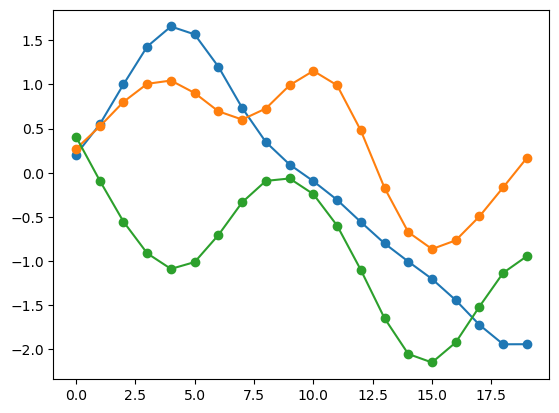

In [5]:
x = np.arange(20)[:, None]
x_prime = x
ell = 3

K = k(x, x_prime, ell)

n_draws = 3
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(len(x)), cov=K), n_draws)

plt.plot(x, s.T, 'o-');

You might ask: 
> This is a draw from 20 dimensional multivariate normal, and sure it's starting to look like data.  How does that relate to a GP, which you said was infinite dimensional?

Look at the lines connecting the dots.  There is an infinite number of $x$ points we *could* evaluate the covariance function over, we just haven't done that.  This is what I meant by GPs are infinite dimensional multivariate normals *that are lazily evaluated*.  Let's simulate infinity by using lots of closely spaced $x$ points over the same domain. 

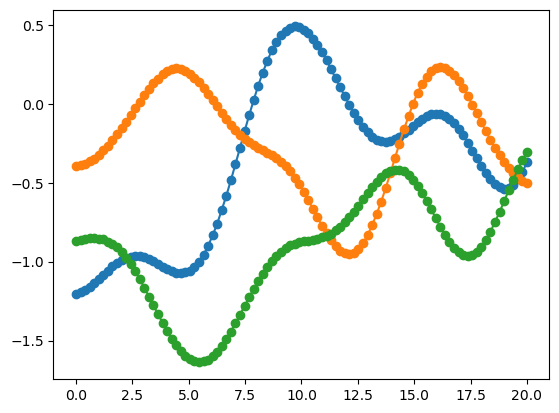

In [6]:
x = np.linspace(0, 20, 100)[:, None]
x_prime = x
ell = 3

K = k(x, x_prime, ell)

n_draws = 3
s = pm.draw(pm.MvNormal.dist(mu=np.zeros(len(x)), cov=K + 1e-6 * np.eye(x.shape[0])), n_draws)
plt.plot(x, s.T, 'o-');

These three draws are clearly represent the same process, and are much smoother because the $x$ points we choose are more closely together.  If we had a big enough computer we could increase the length of $x$ to infinity and make the same plot.  This is the sense how GPs are infinite dimensional multivariate normals.  This idea also underlies how we make predictions with them.  It's possible to forecast the GP posterior at new $x$ points, because the process was already defined over those anyway.

# CO$_2$ Measurements from the Mauna Loa Observatory

This is a fairly common textbook example, but it's a nice one because it'll show off how easy it is to decompose the signal using PyTensor.  I first saw it in Rassmussen and Williams, GPs for Machine Learning book.  Also used it for an example in PyMC.  Next we'll repeat some of the setup from that notebook here, but instead of using the PyMC functionality to fit the GP (which is PyTensor based), we'll use PyTensor directly. 

In [7]:
import pandas as pd

# get data
try:
    data_monthly = pd.read_csv("../data/monthly_in_situ_co2_mlo.csv", header=56)
except FileNotFoundError:
    data_monthly = pd.read_csv(pm.get_data("monthly_in_situ_co2_mlo.csv"), header=56)

# replace -99.99 with NaN
data_monthly.replace(to_replace=-99.99, value=np.nan, inplace=True)

# fix column names
cols = [
    "year",
    "month",
    "--",
    "--",
    "CO2",
    "seasonaly_adjusted",
    "fit",
    "seasonally_adjusted_fit",
    "CO2_filled",
    "seasonally_adjusted_filled",
]
data_monthly.columns = cols
cols.remove("--")
cols.remove("--")
data_monthly = data_monthly[cols]

# drop rows with nan
data_monthly.dropna(inplace=True)

# fix time index
data_monthly["day"] = 15
data_monthly.index = pd.to_datetime(data_monthly[["year", "month", "day"]])
cols.remove("year")
cols.remove("month")
data_monthly = data_monthly[cols]

data_monthly.tail(5)

,CO2,seasonaly_adjusted,fit,seasonally_adjusted_fit,CO2_filled,seasonally_adjusted_filled
2021-11-15,414.82,417.10,414.76,417.02,414.82,417.10
2021-12-15,416.43,417.37,416.31,417.22,416.43,417.37
2022-01-15,418.01,417.95,417.51,417.43,418.01,417.95
2022-02-15,418.99,418.20,418.42,417.63,418.99,418.20
2022-03-15,418.45,416.90,419.37,417.81,418.45,416.90


In [8]:
# function to convert datetimes to indexed numbers that are useful for later prediction
def dates_to_idx(timelist):
    reference_time = pd.to_datetime("1958-03-15")
    t = (timelist - reference_time) / pd.Timedelta(365, "D")
    return np.asarray(t)


t = dates_to_idx(data_monthly.index)

# normalize CO2 levels
y = data_monthly["CO2"].values
first_co2 = y[0]
std_co2 = np.std(y)
y_n = (y - first_co2) / std_co2

data_monthly = data_monthly.assign(t=t)
data_monthly = data_monthly.assign(y_n=y_n)

In [9]:
# split into training and test set
sep_idx = data_monthly.index.searchsorted(pd.to_datetime("2003-12-15"))
data_early = data_monthly.iloc[: sep_idx + 1, :]
data_later = data_monthly.iloc[sep_idx:, :]

In [15]:
# plot training and test data
p = figure(
    x_axis_type="datetime",
    title="Monthly CO2 Readings from Mauna Loa",
    width=1000,
    height=350,
)
p.yaxis.axis_label = "CO2 [ppm]"
p.xaxis.axis_label = "Date"
predict_region = BoxAnnotation(
    left=pd.to_datetime("2003-12-15"), fill_alpha=0.1, fill_color="firebrick"
)
p.add_layout(predict_region)
ppm400 = Span(location=400, dimension="width", line_color="red", line_dash="dashed", line_width=2)
p.add_layout(ppm400)

p.line(data_monthly.index, data_monthly["CO2"], line_width=2, line_color="black", alpha=0.5)
p.scatter(
    data_monthly.index, data_monthly["CO2"], marker="circle", line_color="black", alpha=0.1, size=2
)

train_label = Label(
    x=100,
    y=165,
    x_units="screen",
    y_units="screen",
    text="Training Set",
    border_line_alpha=0.0,
    background_fill_alpha=0.0,
)
test_label = Label(
    x=585,
    y=80,
    x_units="screen",
    y_units="screen",
    text="Test Set",
    border_line_alpha=0.0,
    background_fill_alpha=0.0,
)

p.add_layout(train_label)
p.add_layout(test_label)
show(p)

In [ ]:
Let's build a GP in PyTensor

In [38]:
x_sym = pt.tensor('x', shape=(None, 1))
x_prime_sym = pt.tensor('x_prime', shape=(None, 1))
ell_sym = pt.scalar('ell')

def exp_quad(x, x_prime, ell):
    return pt.exp(-(x - x_prime.T)**2 / (2 * ell**2))

mu = pt.tensor('mu', shape=(None, 1))
K = exp_quad(x_sym, x_prime_sym, ell_sym)

rv = pt.random.multivariate_normal(mu, K)

y = pt.dvector('y')

gp_logp = pm.logp(rv, y)
#fn = pytensor.function([y], pm.logp(rv, y))
#print(fn(np.zeros(10)))

InteractiveRewrite([gp_logp])

Consider two independent GP distributed functions, $f_1(x) \sim
\mathcal{GP}\left(m_1(x),\, k_1(x, x')\right)$ and $f_2(x) \sim
\mathcal{GP}\left( m_2(x),\, k_2(x, x')\right)$. The joint distribution of $f_1,\, f_1^*,\, f_2,\, f_2^*,\, f_1 + f_2$ and $f_1^* + f_2^*$ is
$$
\begin{bmatrix} f_1 \\ f_1^* \\ f_2 \\ f_2^*
             \\ f_1 + f_2    \\ f_1^* + f_2^* \end{bmatrix} \sim
\text{N}\left(
  \begin{bmatrix} m_1 \\ m_1^* \\ m_2 \\ m_2^* \\
                  m_1 + m_2    \\ m_1^* + m_2^*   \\ \end{bmatrix} \,,\,
  \begin{bmatrix}
    K_1       &  K_1^*     &   0       &    0      & K_1        & K_1^*              \\
    K_1^{*^T} &  K_1^{**}  &   0       &    0      & K_1^*      & K_1^{**}           \\
    0         &  0         & K_2       & K_2^*     & K_2        & K_2^{*}            \\
    0         &  0         & K_2^{*^T} & K_2^{**}  & K_2^{*}    & K_2^{**}           \\
    K_1       &  K_1^{*}   & K_2       & K_2^{*}   & K_1 + K_2  & K_1^{*} + K_2^{*}  \\
    K_1^{*^T} & K_1^{**} & K_2^{*^T} & K_2^{**} & K_1^{*^T}+K_2^{*^T} & K_1^{**}+K_2^{**}
  \end{bmatrix}
\right) \,.
$$
Using the joint distribution to obtain the conditional distribution of $f_1^*$ with the contribution due to $f_1 + f_2$ factored out, we get
$$
f_1^* \mid f_1 + f_2 \sim \text{N}\left(
  m_1^* + K_1^{*^T}(K_1 + K_2)^{-1}\left[f_1 + f_2 - m_1 - m_2\right] \,,\,
  K_1^{**} - K_1^{*^T}(K_1 + K_2)^{-1}K_1^* \right) \,.
$$


In [10]:
from bokeh.io import output_notebook
from bokeh.models import BoxAnnotation, Label, Legend, Span
from bokeh.palettes import brewer
from bokeh.plotting import figure, show

output_notebook()

Loading BokehJS ...

In [ ]:
- write about the logp expression below for GPs, write about what pytensor can do
- write about decomposition, in terms of GP equations
- write GP in terms of terms.  

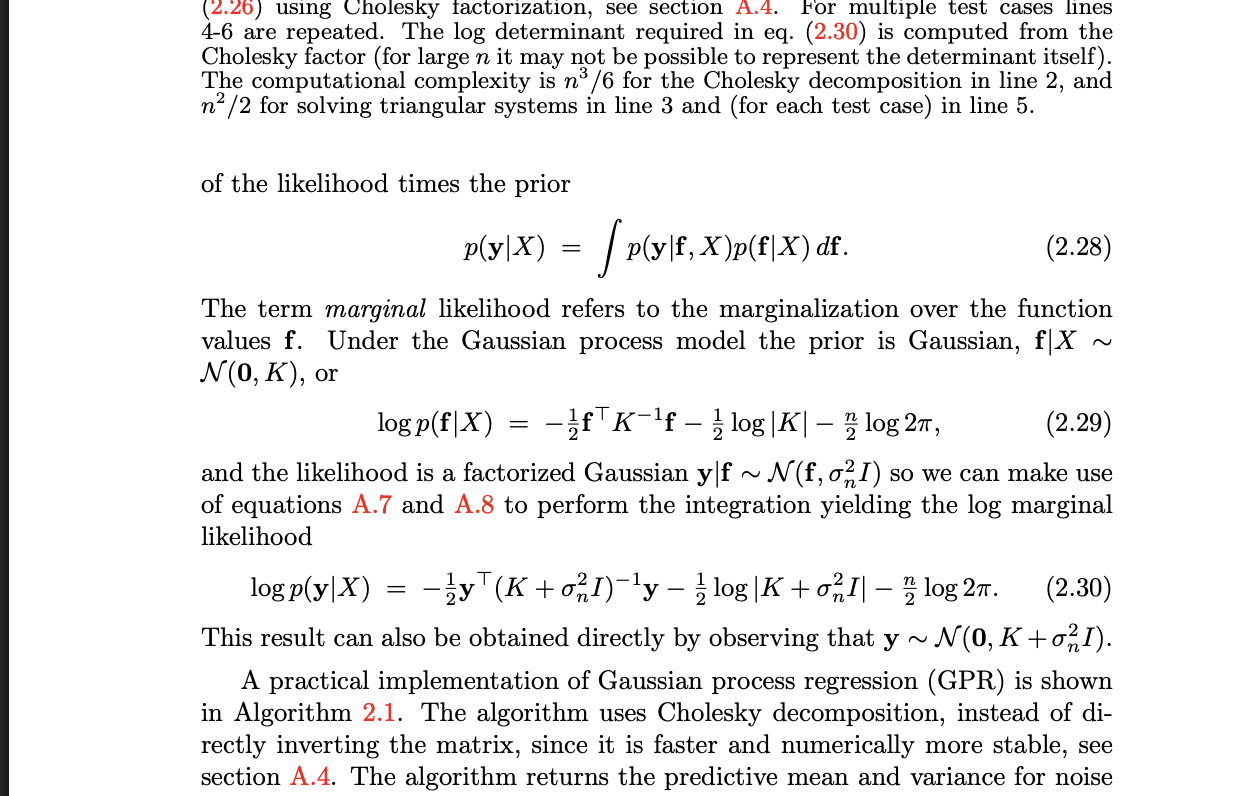

In [11]:
from pytensor.ipython import InteractiveRewrite
import pytensor
import pytensor.tensor as pt

f = pt.dmatrix('f')
K = pt.dmatrix('K')

L = pt.linalg.cholesky(K)
#logp = -0.5 * f.T @ pt.linalg.inv(L @ L.T) @ f
logp = -0.5 * f.T @ pt.linalg.solve(L @ L.T, f, assume_a="pos")
#InteractiveRewrite([logp])

out = pt.linalg.solve(x, y, assume_a='pos')
d_out = pt.grad(out.sum(), x)
#InteractiveRewrite([out])
InteractiveRewrite([out, d_out])

TypeError: unhashable type: 'numpy.ndarray'

In [5]:
pt.linalg.inv?

Signature:      pt.linalg.inv(*inputs: Any, name=None, return_list=False, **kwargs) -> pytensor.graph.basic.Variable | list[pytensor.graph.basic.Variable]
Type:           Blockwise
String form:    Blockwise{MatrixInverse, (m,m)->(m,m)}
File:           ~/miniconda3/envs/basic/lib/python3.11/site-packages/pytensor/tensor/blockwise.py
Docstring:     
Generalizes a core `Op` to work with batched dimensions.

TODO: C implementation?
TODO: Fuse Blockwise?
Init docstring:
Parameters
----------
core_op
    An instance of a subclass of `Op` which works on the core case.
signature
    Generalized universal function signature,
    e.g., (m,n),(n)->(m) for vectorized matrix-vector multiplication
gufunc: tuple, Optional
    Tuple containing:
        1. String import path for a numpy/scipy function (e.g., "numpy.matmul", "scipy.special.softmax")
        that implements the blockwised operation of the scalar op.
        2 Number of inputs of the function
        3 Number of outputs of the function
Ca

In [8]:
import scipy as sp

sp.linalg.inv?

Signature: sp.linalg.inv(a, overwrite_a=False, check_finite=True)
Docstring:
Compute the inverse of a matrix.


The documentation is written assuming array arguments are of specified
"core" shapes. However, array argument(s) of this function may have additional
"batch" dimensions prepended to the core shape. In this case, the array is treated
as a batch of lower-dimensional slices; see :ref:`linalg_batch` for details.

Parameters
----------
a : array_like
    Square matrix to be inverted.
overwrite_a : bool, optional
    Discard data in `a` (may improve performance). Default is False.
check_finite : bool, optional
    Whether to check that the input matrix contains only finite numbers.
    Disabling may give a performance gain, but may result in problems
    (crashes, non-termination) if the inputs do contain infinities or NaNs.

Returns
-------
ainv : ndarray
    Inverse of the matrix `a`.

Raises
------
LinAlgError
    If `a` is singular.
ValueError
    If `a` is not square, or not 2